In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import nbimporter
from diametre_monnaie import conversion_piece
from tooth_pattern import draw_tooth_pattern
from tooth_pattern import match

In [36]:
image_path = '../DataBase/image10.jpg' 

reference_object_mm = 22.6  # diamètre de la pièce de monnaie en mm 

# Les dimensions réelles en millimètres de la piece 

diametre_reel_mm = 20  # Diamètre réel du filetage en mm  
pas_reel_mm = 25.4 / 14 # Pas réel du filetage en mm

In [43]:
def extract_line_pixels(img, start_point, end_point):
    height, width = img.shape[:2]  # Obtenir les dimensions de l'image
    num_points = max(abs(end_point[1] - start_point[1]), abs(end_point[0] - start_point[0]))
    
    x_values = np.linspace(start_point[0], end_point[0], num=num_points, endpoint=False).astype(int)
    y_values = np.linspace(start_point[1], end_point[1], num=num_points, endpoint=False).astype(int)
    
    x_values = np.clip(x_values, 0, width-1)
    y_values = np.clip(y_values, 0, height-1)
    
    pixel_values = img[y_values, x_values]
    
    return pixel_values

In [44]:
def match_and_draw_normal_and_analyze(image_path, pas_reel_mm, reference_object_mm, rotation):

    template = draw_tooth_pattern(image_path, pas_reel_mm, reference_object_mm, rotation)
    img_with_rectangle, res, max_val = match(template, image_path)
    
    img_color = cv2.imread(image_path)
    
    img_filtered = cv2.bilateralFilter(img_color, d=9, sigmaColor=75, sigmaSpace=75)
    
    gray = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray)
    
    thresh = cv2.adaptiveThreshold(gray_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)
    
    cv2.imwrite('try.jpg', thresh)
    w, h = template.shape[::-1]
    top_left = cv2.minMaxLoc(res)[3]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    center = ((top_left[0] + bottom_right[0]) // 2, (top_left[1] + bottom_right[1]) // 2)
    
    length = 2000 #à ajuster
    start_point = (center[0], center[1] - length // 2)
    end_point = (center[0], center[1] + length // 2)
    
    pixel_values = extract_line_pixels(gray, start_point, end_point)
    

    return pixel_values

In [45]:
pixel_values = match_and_draw_normal_and_analyze(image_path, pas_reel_mm, reference_object_mm, False)

TypeError: draw_tooth_pattern() missing 1 required positional argument: 'rotation'

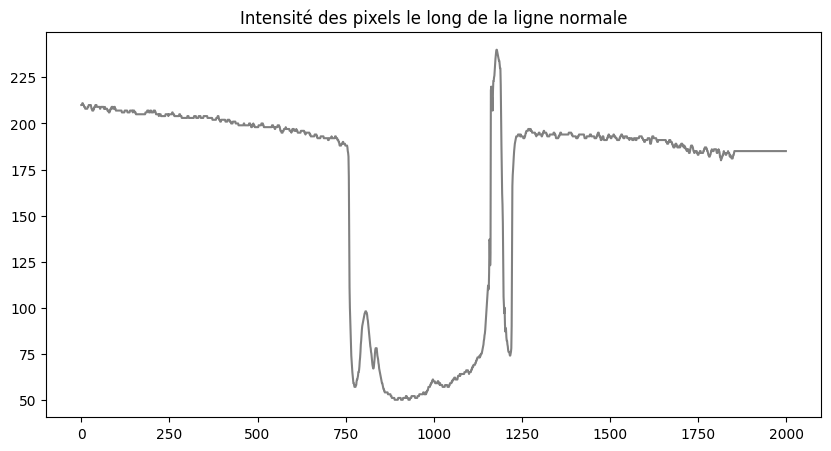

In [46]:
plt.figure(figsize=(10, 5))

plt.plot(pixel_values, color='gray')
    
plt.title('Intensité des pixels le long de la ligne normale')
plt.show()

In [47]:
def diameter_filtage(pixel_values):
    max_diff = 8
    begin = 0
    end = len(pixel_values) - 1

    pixel_values = np.array(pixel_values, dtype=np.int64)

    for i in range(len(pixel_values) - 1):
        diff = abs(int(pixel_values[i]) - int(pixel_values[i + 1]))
        if diff > max_diff:
            begin = i + 1
            break

    for i in range(len(pixel_values) - 1, 0, -1):
        diff = abs(int(pixel_values[i]) - int(pixel_values[i - 1]))
        if diff > max_diff:
            end = i
            break 

    return end - begin

In [48]:
diameter_filtage(pixel_values)

464